# Autoencoder of a Large Dataset (IXI)

First of all, check the parametrers

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1

In [2]:
import os
#import cv2
import keras
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.


In [3]:
# Muestro la version de keras
keras.__version__

'2.3.1'

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [5]:
get_available_gpus()

['/device:GPU:0']

In [6]:
#import tensorflow as tf
#tf.test.is_gpu_available() Deprecated
#tf.config.list_physical_devices('GPU')

In [7]:
#tf.config.experimental.list_physical_devices('GPU')

In [8]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import math
import glob
from matplotlib import pyplot as plt
import h5py
%matplotlib inline

The path of file previously created is initialized.

In [10]:
file_path="./IXI-T1-H5PY/mri.hdf5"

In [11]:
# Show the shape of the file created
f = h5py.File(file_path, "r")
dset = f['mri']
print(dset.shape)
f.close()

(581, 130, 256, 256)


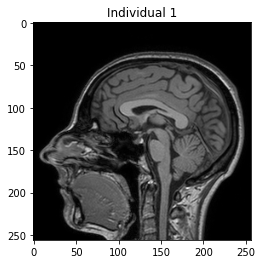

In [12]:
# Plot sagittal image of first individual
f = h5py.File(file_path, "r")
dset = f['mri']
plt.imshow(dset[0][64].reshape(256,256), cmap="gray", animated=True)
plt.title("Individual 1")
plt.show()
f.close()

In [13]:
# Show the number of individuals or lenght of file
f = h5py.File(file_path, "r")
dset = f['mri']
print("There are %d individuals." % dset.len())
f.close()

There are 581 individuals.


# Autoencoder creation: The Convolutional Autoencoder.

A first autoencoder is created

In [14]:
# Autoencoder is created
# Reference:
# https://www.datacamp.com/community/tutorials/reconstructing-brain-images-deep-learning

inChannel = 1
# x, y = 256, 320
x, y = 256, 256
input_img = Input(shape = (x, y, inChannel))

def autoencoder(input_img):
    #encoder
    #input = 256 x 256 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [15]:
# Compilation
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy'])
#autoencoder.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [16]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      1849

# Creation of train and validation generators

In order to train the model with a large dataset is required to used fit_generator with train and validation generators

In [17]:
mri_h5py_path = file_path

In [23]:
import gc
V_WIDTH=130
NUM_SLICES=20
MIN=V_WIDTH//2-NUM_SLICES
MAX=V_WIDTH//2+NUM_SLICES
NUM_EPOCHS=40

In [19]:
# Reference:
# https://riptutorial.com/keras/example/29807/training-a-model-to-classify-videos
def generate_training_sequences(batch_size, mri_data, training_sample_idxs):
    """ Generates training sequences on demand
    """
    while True:
        # generate sequences for training
        training_sample_count = len(training_sample_idxs)
        batches = int(training_sample_count/batch_size)
        remainder_samples = training_sample_count%batch_size
        if remainder_samples:
            batches = batches + 1
        # generate batches of samples
        for idx in range(0, batches):
            if idx == batches - 1:
                batch_idxs = training_sample_idxs[idx*batch_size:]
            else:
                batch_idxs = training_sample_idxs[idx*batch_size:idx*batch_size+batch_size]
            batch_idxs = sorted(batch_idxs)
            
            #X=np.zeros(shape=mri_data[0,::].shape, dtype=mri_data[0,::].dtype)
            #X = []
            for bidx in batch_idxs:
                if bidx == batch_idxs[0] :
                    B=mri_data[bidx,::]
                    X=B[MIN:MAX,]
                else:
                #X=X.append(mri_data[bidx,::].reshape(-1,256,256,1))     
                #X=X.append((mri_data[bidx,::]))
                    B=mri_data[bidx,::]
                    B=B[MIN:MAX,]
                    X=np.append(arr=X, values=B, axis=0)
                
                
            X = np.asarray(X)
            X = X.reshape(-1,256,256,1)
            gc.collect()
            #train
            #X = mri_data[[batch_idxs],::].reshape(-1,256,256,1)
            #Y = mri_data["Y"][batch_idxs]

            yield X, X

            
def generate_validation_sequences(batch_size, mri_data, validation_sample_idxs):
    """ Generates validation sequences on demand
    """
    while True:
        # generate sequences for validation
        validation_sample_count = len(validation_sample_idxs)
        batches = int(validation_sample_count/batch_size)
        remainder_samples = validation_sample_count%batch_size
        if remainder_samples:
            batches = batches + 1
        # generate batches of samples
        for idx in range(0, batches):
            if idx == batches - 1:
                batch_idxs = validation_sample_idxs[idx*batch_size:]
            else:
                batch_idxs = validation_sample_idxs[idx*batch_size:idx*batch_size+batch_size]
            batch_idxs = sorted(batch_idxs)

            #X=np.zeros(shape=mri_data[0,::].shape, dtype=mri_data[0,::].dtype)
            #X = []
            for bidx in batch_idxs:
                if bidx == batch_idxs[0] :
                    B=mri_data[bidx,::]
                    X=B[MIN:MAX,]
                else:
                #X=X.append(mri_data[bidx,::].reshape(-1,256,256,1))     
                #X=X.append((mri_data[bidx,::]))
                    B=mri_data[bidx,::]
                    B=B[MIN:MAX,]
                    X=np.append(arr=X, values=B, axis=0)

                
            X = np.asarray(X)
            X = X.reshape(-1,256,256,1)
            gc.collect()
            #X = mri_data[[batch_idxs],::].reshape(-1,256,256,1)
            #Y = video_data["Y"][batch_idxs]

            yield X, X

In [20]:
def train_model(model, mri_data_fn=mri_h5py_path, validation_ratio=0.2, batch_size=1):
    """ Train the autoencoder model
    """
    with h5py.File(mri_data_fn, "r") as mri_data:
        dset = mri_data["mri"]           
        sample_count = dset.len()
        sample_idxs = range(0, sample_count)
        sample_idxs = np.random.permutation(sample_idxs)
        training_sample_idxs = sample_idxs[0:int((1-validation_ratio)*sample_count)]
        validation_sample_idxs = sample_idxs[int((1-validation_ratio)*sample_count):]
        training_sequence_generator = generate_training_sequences(batch_size=batch_size,
                                                                  mri_data=dset,
                                                                  training_sample_idxs=training_sample_idxs)
        validation_sequence_generator = generate_validation_sequences(batch_size=batch_size,
                                                                      mri_data=dset,
                                                                      validation_sample_idxs=validation_sample_idxs)
        history = model.fit_generator(generator=training_sequence_generator,
                             validation_data=validation_sequence_generator,
                             samples_per_epoch=len(training_sample_idxs),
                             nb_val_samples=len(validation_sample_idxs),
                             nb_epoch=NUM_EPOCHS,
                             max_q_size=1,
                             verbose=2,
                             class_weight=None,
                             nb_worker=1)
        return history
        

In [21]:
h = train_model(autoencoder)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., validation_data=<generator..., verbose=2, class_weight=None, steps_per_epoch=464, epochs=40, validation_steps=117, workers=1, max_queue_size=1)`


Epoch 1/40
 - 538s - loss: 0.0185 - accuracy: 0.2012 - val_loss: 0.0088 - val_accuracy: 0.2042
Epoch 2/40
 - 533s - loss: 0.0042 - accuracy: 0.2034 - val_loss: 0.0024 - val_accuracy: 0.2042
Epoch 3/40
 - 531s - loss: 0.0023 - accuracy: 0.2035 - val_loss: 0.0016 - val_accuracy: 0.2042
Epoch 4/40
 - 532s - loss: 0.0017 - accuracy: 0.2035 - val_loss: 0.0016 - val_accuracy: 0.2042
Epoch 5/40
 - 534s - loss: 0.0013 - accuracy: 0.2035 - val_loss: 0.0012 - val_accuracy: 0.2042
Epoch 6/40
 - 532s - loss: 0.0012 - accuracy: 0.2035 - val_loss: 8.5537e-04 - val_accuracy: 0.2042
Epoch 7/40
 - 527s - loss: 0.0011 - accuracy: 0.2035 - val_loss: 8.2413e-04 - val_accuracy: 0.2042
Epoch 8/40
 - 524s - loss: 9.7597e-04 - accuracy: 0.2035 - val_loss: 0.0011 - val_accuracy: 0.2042
Epoch 9/40
 - 524s - loss: 9.0872e-04 - accuracy: 0.2035 - val_loss: 7.7418e-04 - val_accuracy: 0.2042
Epoch 10/40
 - 524s - loss: 8.4596e-04 - accuracy: 0.2035 - val_loss: 7.0176e-04 - val_accuracy: 0.2042
Epoch 11/40
 - 522s -

In [22]:
h.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

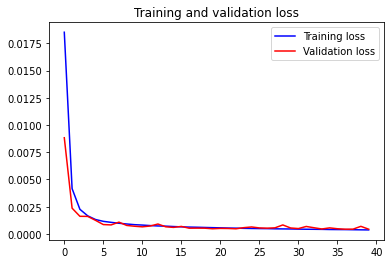

In [30]:
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(NUM_EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

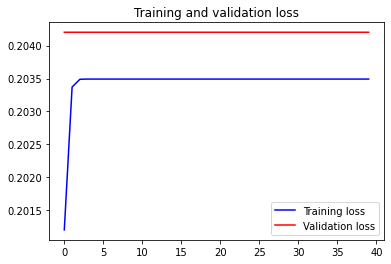

In [31]:
loss = h.history['accuracy']
val_loss = h.history['val_accuracy']
epochs = range(NUM_EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [34]:
# String with timestamp
from datetime import datetime
datetime = datetime.now().strftime('%Y%m%d%H%M%S')
print(datetime)

20200405071820


In [35]:
# Reference
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# Serialize model to JSON
autoencoder_json = autoencoder.to_json()
with open('ae' + datetime + '.json', "w") as json_file:
    json_file.write(autoencoder_json)
# Serialize weights to HDF5
autoencoder_saved = autoencoder.save_weights('ae' + datetime +'_mri.h5')
print("Saved model to disk")

Saved model to disk


# Predicting on Validation Data

In [36]:
# load json and create model
from keras.models import model_from_json
json_file = open("ae" + datetime+ ".json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      1849

In [37]:
# load weights into new model
loaded_model.load_weights("ae" + datetime + "_mri.h5")

In [133]:
# TODO: Train and validate with part of the set and validate with other samples
TEST_SIZE=5
valid_X = []
with h5py.File(mri_h5py_path, "r") as mri_data:
    dset = mri_data["mri"]           
    sample_count = dset.len()
    sample_idxs = range(0, sample_count)
    sample_idxs = np.random.permutation(sample_idxs)
    validation_sample_idxs = sample_idxs[-TEST_SIZE:]
    for index in validation_sample_idxs:
        X = dset[index,::]
        X = X[MIN:MAX,::]
        X.reshape(-1,256,256,1)
        valid_X.append(X)
        

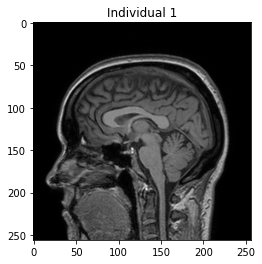

In [134]:
plt.imshow(valid_X[0][20].reshape(256,256), cmap="gray", animated=True)
plt.title("Individual 1")
plt.show()
f.close()

In [135]:
predictions = []
for elem in valid_X:
    pred = loaded_model.predict(elem.reshape(-1,256,256,1))
    predictions.append(pred)

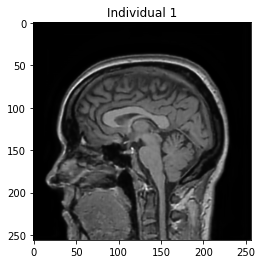

In [136]:
plt.imshow(predictions[0][20].reshape(256,256), cmap="gray", animated=True)
plt.title("Individual 1")
plt.show()
f.close()

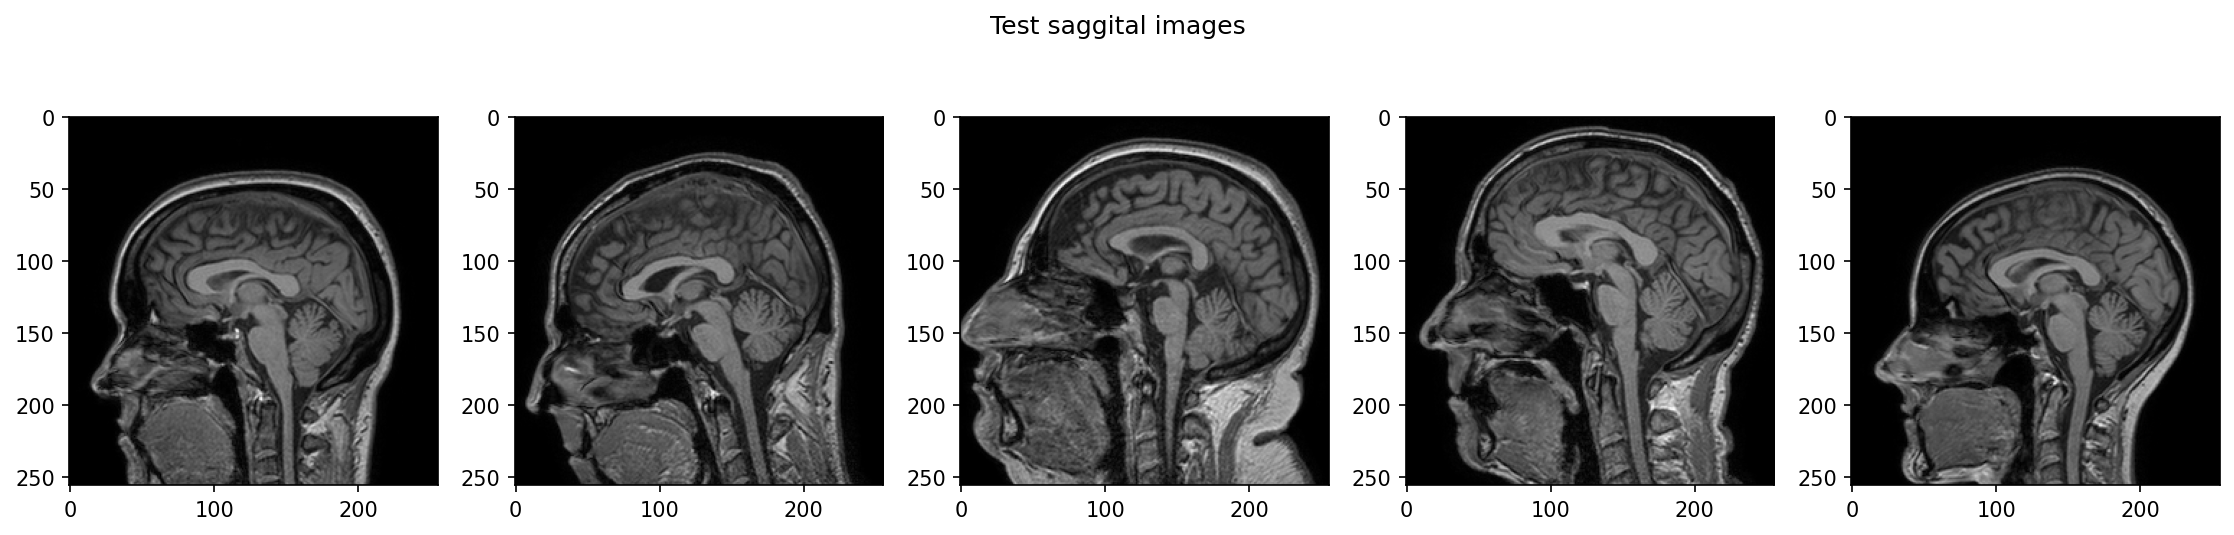

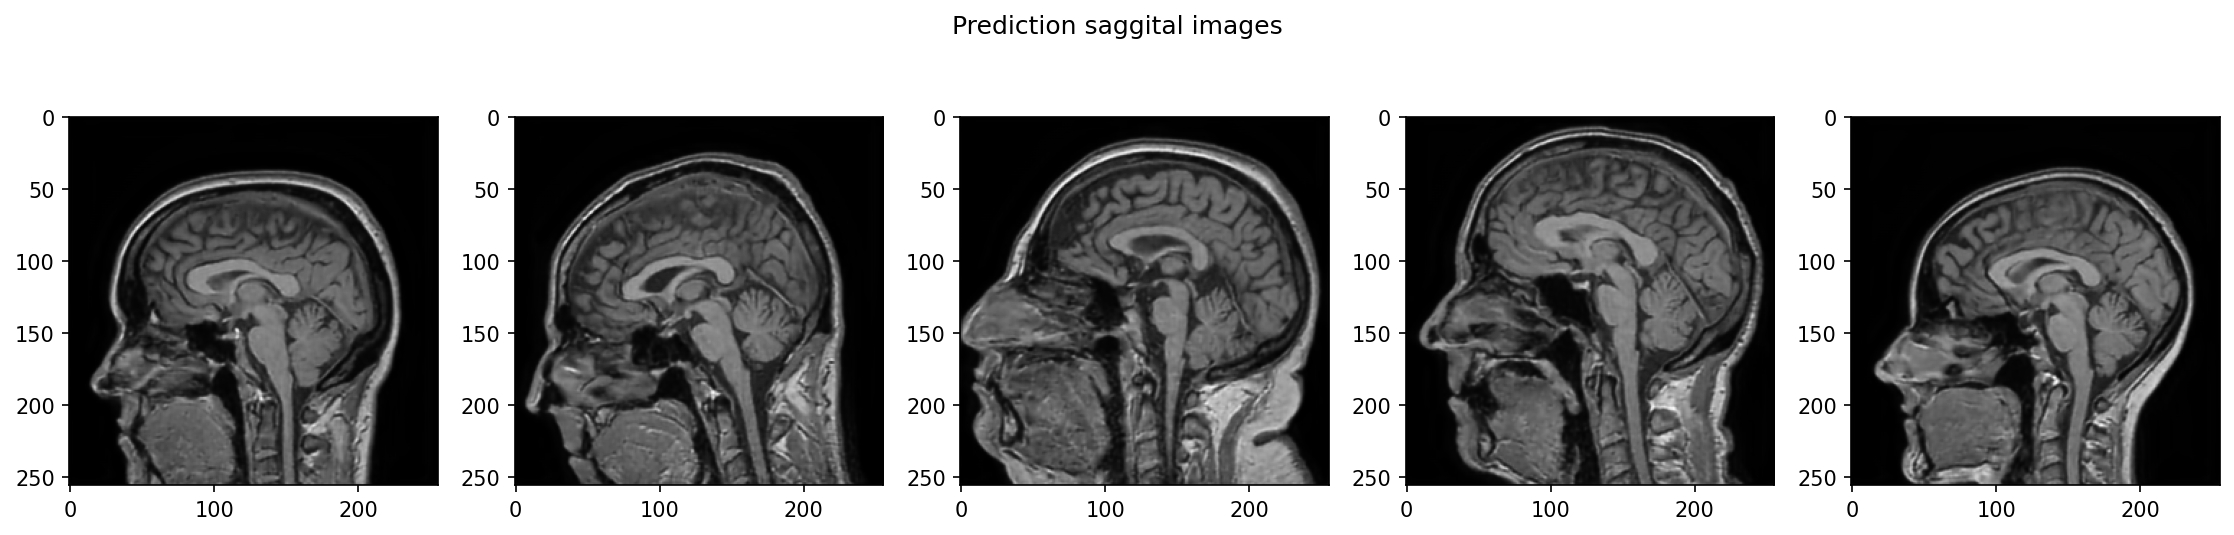

In [138]:
# Representing the figures
FIGS_PER_LINE=5
MIDDLE = 20
fig_x = 15
fig_y = 8
fig1 = plt.figure(figsize=(fig_x,fig_y), dpi=150)
fig1.suptitle('Test saggital images')
for i, j in zip(range(len(valid_X)),range(1,len(valid_X)+1)):
    ax = fig1.add_subplot(len(valid_X)//FIGS_PER_LINE + 1, FIGS_PER_LINE, j) 
    #ax.annotate("Individual %d" % j,(3,3),bbox={'facecolor':'white'},fontsize=16)
    #ax.annotate(individuals[i][9:-7],(3,3),bbox={'facecolor':'white'},fontsize=14)
    plt.imshow(valid_X[i][MIDDLE].reshape(256,256), cmap="gray")
plt.tight_layout()
#plt.savefig('IXI-T1.png', dpi=150)
fig2 = plt.figure(figsize=(fig_x,fig_y), dpi=150)
fig2.suptitle('Prediction saggital images')
for i, j in zip(range(len(predictions)),range(1,len(predictions)+1)):
    ax = fig2.add_subplot(len(predictions)//FIGS_PER_LINE + 1, FIGS_PER_LINE, j) 
    #ax.annotate("Individual %d" % j,(3,3),bbox={'facecolor':'white'},fontsize=16)
    #ax.annotate(individuals[i][9:-7],(3,3),bbox={'facecolor':'white'},fontsize=14)
    plt.imshow(predictions[i][MIDDLE].reshape(256,256), cmap="gray")
plt.tight_layout()
plt.savefig('Test and predictions.png', dpi=150)
plt.show()


In [139]:
# Test with noisy images
[a,b,c]= np.shape(valid_X[0])
mean = 0
sigma = 0.03
gauss = np.random.normal(mean,sigma,(a,b,c))
noisy_images = []
for elem in valid_X:
    noisy_images.append(elem + gauss)

In [140]:
pred_noisy = []
for elem in noisy_images:
    pred = loaded_model.predict(elem.reshape(-1,256,256,1))
    pred_noisy.append(pred)

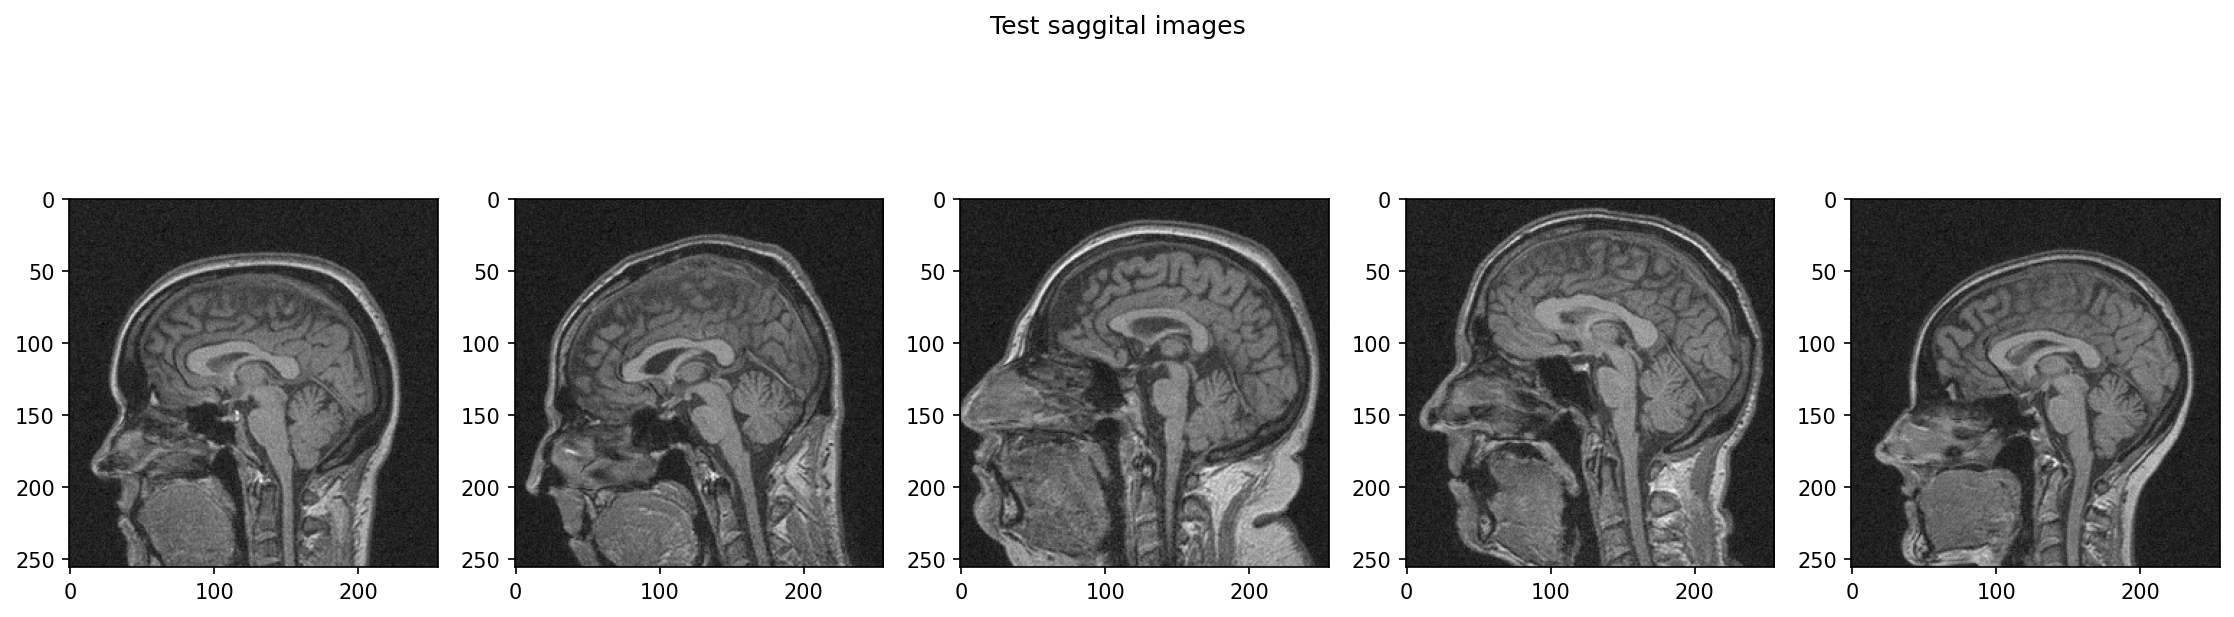

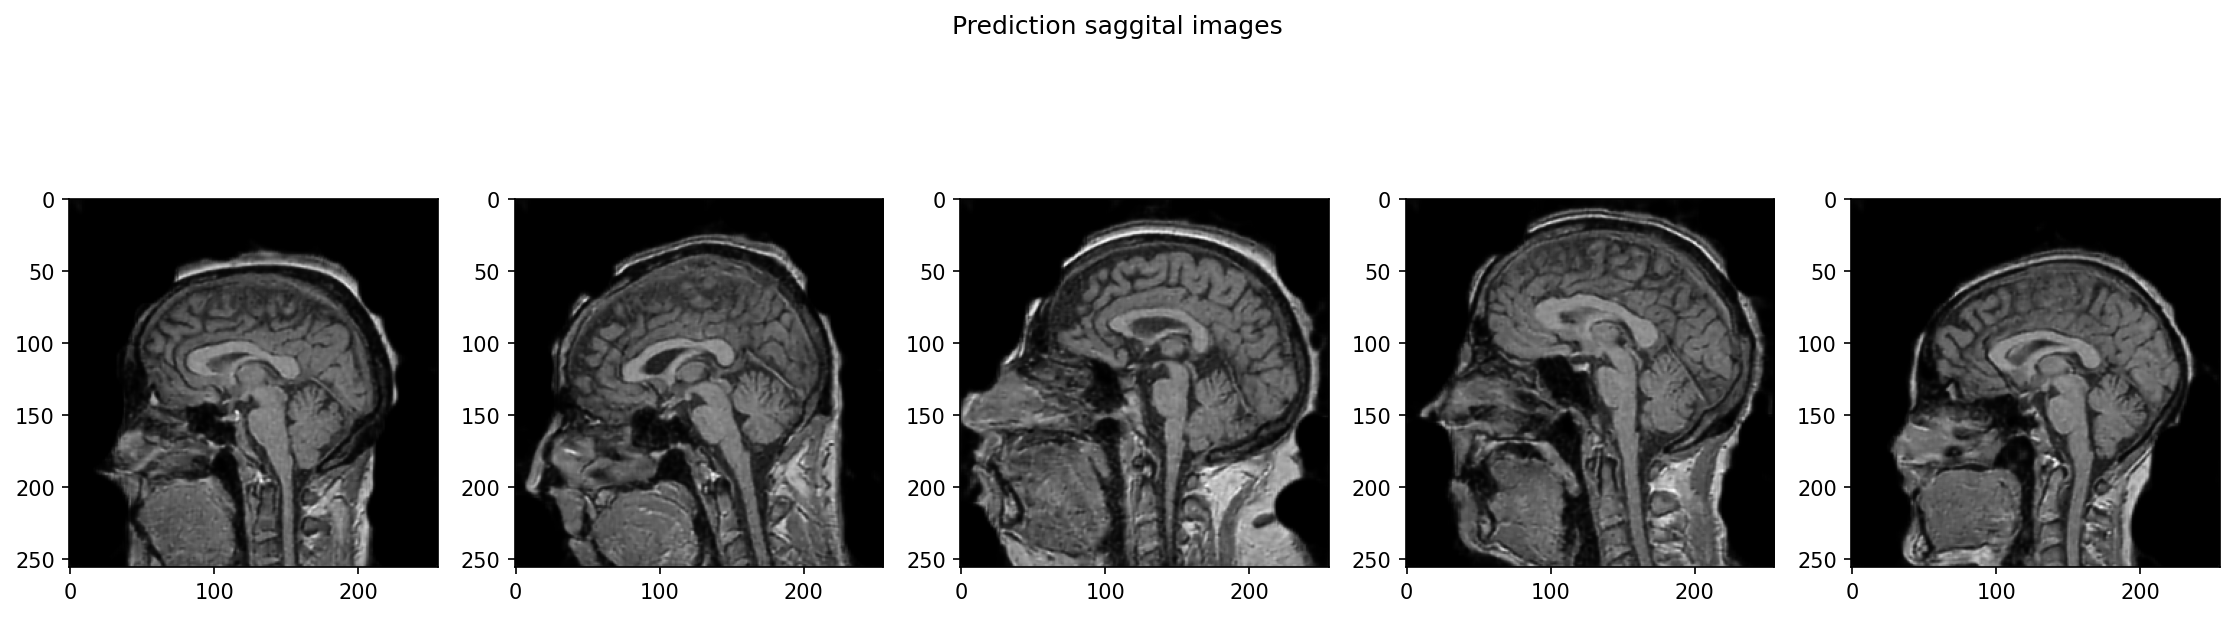

In [141]:
# Representing the figures
FIGS_PER_LINE=5
MIDDLE = 20
fig_x = 15
fig_y = 10
fig1 = plt.figure(figsize=(fig_x,fig_y), dpi=150)
fig1.suptitle('Test saggital images')
for i, j in zip(range(len(noisy_images)),range(1,len(noisy_images)+1)):
    ax = fig1.add_subplot(len(noisy_images)//FIGS_PER_LINE + 1, FIGS_PER_LINE, j) 
    #ax.annotate("Individual %d" % j,(3,3),bbox={'facecolor':'white'},fontsize=16)
    #ax.annotate(individuals[i][9:-7],(3,3),bbox={'facecolor':'white'},fontsize=14)
    plt.imshow(noisy_images[i][MIDDLE].reshape(256,256), cmap="gray")
plt.tight_layout()
#plt.savefig('IXI-T1.png', dpi=150)
fig2 = plt.figure(figsize=(fig_x,fig_y), dpi=150)
fig2.suptitle('Prediction saggital images')
for i, j in zip(range(len(pred_noisy)),range(1,len(pred_noisy)+1)):
    ax = fig2.add_subplot(len(pred_noisy)//FIGS_PER_LINE + 1, FIGS_PER_LINE, j) 
    #ax.annotate("Individual %d" % j,(3,3),bbox={'facecolor':'white'},fontsize=16)
    #ax.annotate(individuals[i][9:-7],(3,3),bbox={'facecolor':'white'},fontsize=14)
    plt.imshow(pred_noisy[i][MIDDLE].reshape(256,256), cmap="gray")
plt.tight_layout()
plt.savefig('Test noisy and predictions.png', dpi=150)
plt.show()

# Quantitative Metric: Peak Signal-to-Noise Ratio (PSNR)

In [145]:
#valid_pred = autoencoder.predict(valid_X)
mse =  np.mean((np.asarray(valid_X).reshape(-1,40,256,256) - np.asarray(predictions).reshape(-1,40,256,256)) ** 2)
psnr = 20 * math.log10( 1.0 / math.sqrt(mse))

In [146]:
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr,2)))

PSNR of reconstructed validation images: 33.89dB


In [147]:
#noisy_pred = autoencoder.predict(noisy_images)
#mse =  np.mean((valid_X - noisy_pred) ** 2)
mse =  np.mean((np.asarray(valid_X).reshape(-1,40,256,256) - np.asarray(pred_noisy).reshape(-1,40,256,256)) ** 2)
psnr_noisy = 20 * math.log10( 1.0 / math.sqrt(mse))

In [148]:
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr_noisy,2)))

PSNR of reconstructed validation images: 25.75dB


Comparing with first autoencoder sample trained with 40 samples and 300 epochs it could be said that is more important the number of epochs that is trained than the sample size. 
TO DO: It is required to train with more epochs the model and compare results. The training time can be around 44 hours.